In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import scipy.interpolate
%matplotlib inline
import seaborn as sns
import os

In [2]:
folder = '../'

In [11]:
pe = pd.read_csv(os.path.join(folder, 'photoexcited_particles.csv'),
                 sep=' ', names=['id', 'x', 'y', 'Ei'], header=0)
pe['x'] *= 1e9
pe['y'] *= 1e9

em = pd.read_csv(os.path.join(folder, 'emitted.csv'),
                 sep=' ', names=['id', 'time', 'Ef'], header=0)
em['time'] *= 1e12

df = em.merge(pe, on='id')
print(df.shape)

(20580, 6)


In [12]:
potential = pd.read_csv(os.path.join(folder, 'potential000.xyz'),
                        sep=' ', names=['x', 'y', 'V'], header=0)
band = potential[potential.y==0.1][['x']].copy()
band['V'] = potential[potential.y==0.1].V * -1
band['V'] += np.abs(band.iloc[0].V)
band['x'] *= 1e3

In [13]:
efield = pd.read_csv(os.path.join(folder, 'x_Efield000.xyz'),
                     sep=' ', names=['x', 'y', 'F'], header=0)
efield = efield[efield.y==0.1][['x', 'F']]
efield['x'] *= 1e3

In [1]:
fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()
ax.plot(band.x, band.V, c='k')
ax2.semilogy(efield.x, efield.F)

NameError: name 'plt' is not defined

In [15]:
valley_offset = np.zeros(10)
valley_offset[2] = 1.34
valley_offset[3] = 2.14

In [16]:
tr = pd.read_csv(os.path.join(folder, 'tracking.csv'),
                 sep=' ', names=['id', 'time', 'x', 'y', 'E', 'valley'], header=0)
tr['x'] *= 1e9
tr['y'] *= 1e9
tr['time'] *= 1e12
tr['Eadj'] = tr.E + [valley_offset[v] for v in tr.valley]

In [17]:
#list(em.id.sample(5))

[435997, 43286, 375056, 386516, 328917]

In [20]:
pids = tr.id.unique()
len(pids)

5494

In [22]:
em[em.id.isin(pids)].shape

(207, 3)

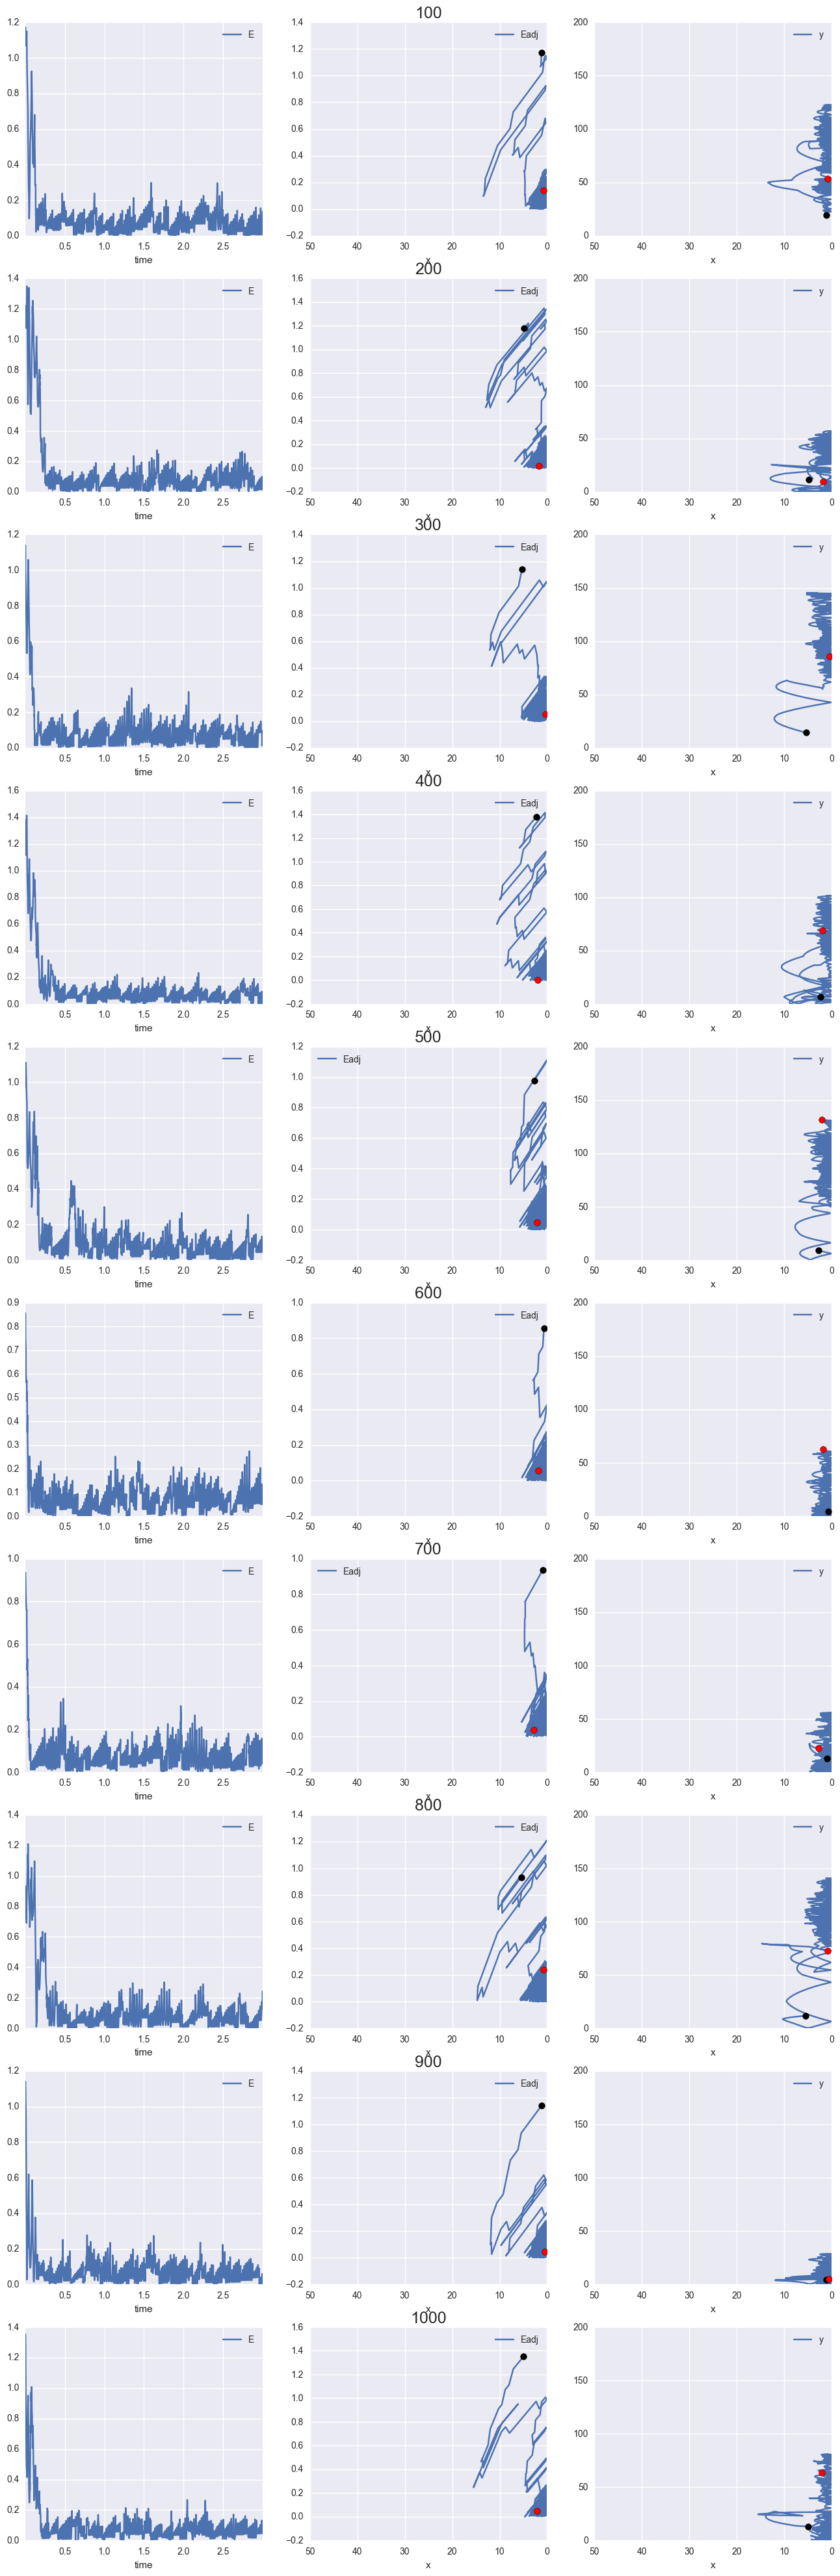

In [25]:
fig, axes = plt.subplots(10, 3, figsize=(16, 10 * 5))
for pid, ax in zip(pids[:10], axes):
    tmp = tr[tr.id==pid]
    tmp.plot(x='time', y='E', ax=ax[0])
    tmp.plot(x='x', y='Eadj', ax=ax[1], xlim=(max(50., tmp.x.max() * 1.1), 0))
    ax[1].scatter(tmp.x.iloc[0], tmp.E.iloc[0], c='k', s=50, zorder=10)
    ax[1].scatter(tmp.x.iloc[-1], tmp.E.iloc[-1], c='r', s=50, zorder=10)
    tmp.plot(x='x', y='y', ax=ax[2], xlim=(max(50., tmp.x.max() * 1.1), 0), ylim=(0, 200))
    ax[2].scatter(tmp.x.iloc[0], tmp.y.iloc[0], c='k', s=50, zorder=10)
    ax[2].scatter(tmp.x.iloc[-1], tmp.y.iloc[-1], c='r', s=50, zorder=10)
    ax[1].set_title(pid, fontsize=18)

In [55]:
band_inter = scipy.interpolate.interp1d(band.x, band.V, bounds_error=False, fill_value=0.)
def band_around(x):
    return band_inter(x)
#     return band[band.x>=x].iloc[0].V

In [40]:
def plot_xy_trajectory(data, pid, cmap=None, ax=None):
    cmap = cmap or sns.dark_palette('purple', as_cmap=True)
    df = data[data.id==pid][['x', 'y']]
    xy = df.as_matrix().reshape(-1, 1, 2)
    segments = np.hstack([xy[:-1], xy[1:]])

    coll = LineCollection(segments, cmap=cmap)
    coll.set_array(np.arange(0.0, 1.0, 1.0 / xy.shape[0]))

    if ax is None:
        fig, ax = plt.subplots()
    ax.add_collection(coll)
    ax.autoscale_view()
    ax.scatter(df['x'].iloc[[0, -1]].as_matrix(),
               df['y'].iloc[[0, -1]].as_matrix(),
               c=[0.0, 1.0], s=50, cmap=cmap)
    ax.set_xlim(0, max(50., df.x.max() * 1.1))
    ax.set_ylim(0, 200)

In [41]:
def plot_energy_valley(data, pid, cmap=None, ax=None):
    cmap = cmap or plt.cm.coolwarm
    df = data[data.id==pid][['x', 'Eadj']]
    xy = df.as_matrix().reshape(-1, 1, 2)
    segments = np.hstack([xy[:-1], xy[1:]])

    coll = LineCollection(segments, cmap=cmap)
    coll.set_array(data[data.id==pid].valley - 1.0)

    if ax is None:
        fig, ax = plt.subplots()
    ax.add_collection(coll)
    ax.autoscale_view()
    ax.scatter(df['x'].iloc[[0, -1]].as_matrix(),
               df['Eadj'].iloc[[0, -1]].as_matrix(),
               c=[0.0, 1.0], s=50, cmap=cmap)

In [42]:
def plot_energy_band(data, pid, cmap=None, ax=None):
    cmap = cmap or plt.cm.coolwarm
    df = data[data.id==pid][['x']].copy()
    df['V'] = data[data.id==pid].Eadj + [band_around(_) for _ in df.x]
    xy = df.as_matrix().reshape(-1, 1, 2)
    segments = np.hstack([xy[:-1], xy[1:]])

    coll = LineCollection(segments, cmap=cmap)
    coll.set_array(data[data.id==pid].valley - 1.0)

    if ax is None:
        fig, ax = plt.subplots()
    ax.axhline(3.18, c='k', ls='--', lw=1)
    band.plot(x='x', y='V', c='k', ax=ax, xlim=(0, max(50, df.x.max() * 1.1)), legend=False)
    ax.add_collection(coll)
    ax.autoscale_view()
    ax.scatter(df['x'].iloc[[0, -1]].as_matrix(),
               df['V'].iloc[[0, -1]].as_matrix(),
               c=[0.0, 1.0], s=50, cmap=cmap, zorder=10)

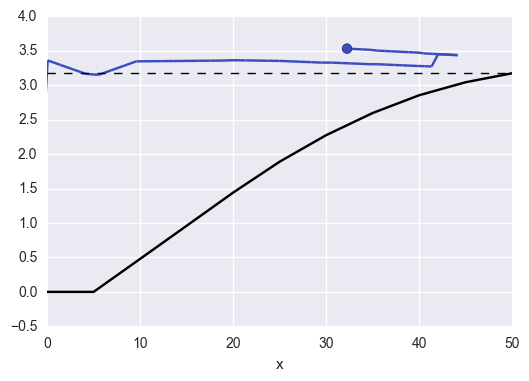

In [56]:
plot_energy_band(tr, pids[239])

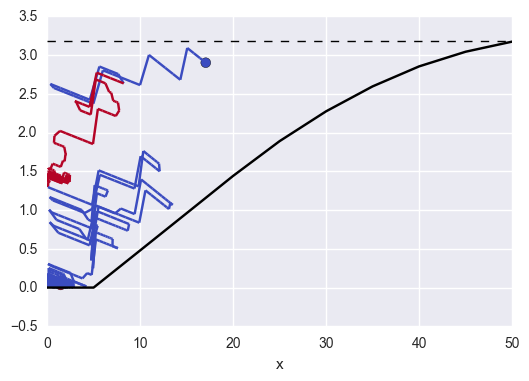

In [441]:
plot_energy_band(tr, pids[1])

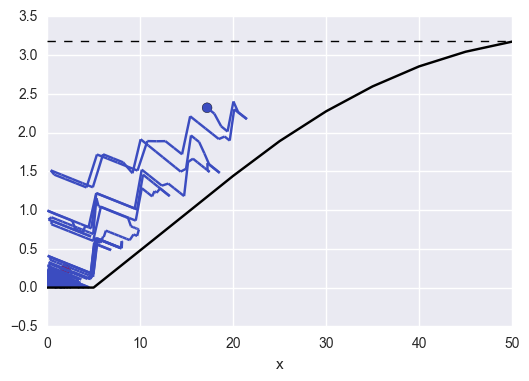

In [442]:
plot_energy_band(tr, pids[2])

In [453]:
band_around(21) - 3.42 + 5 - 3.18

0.28946099999999975

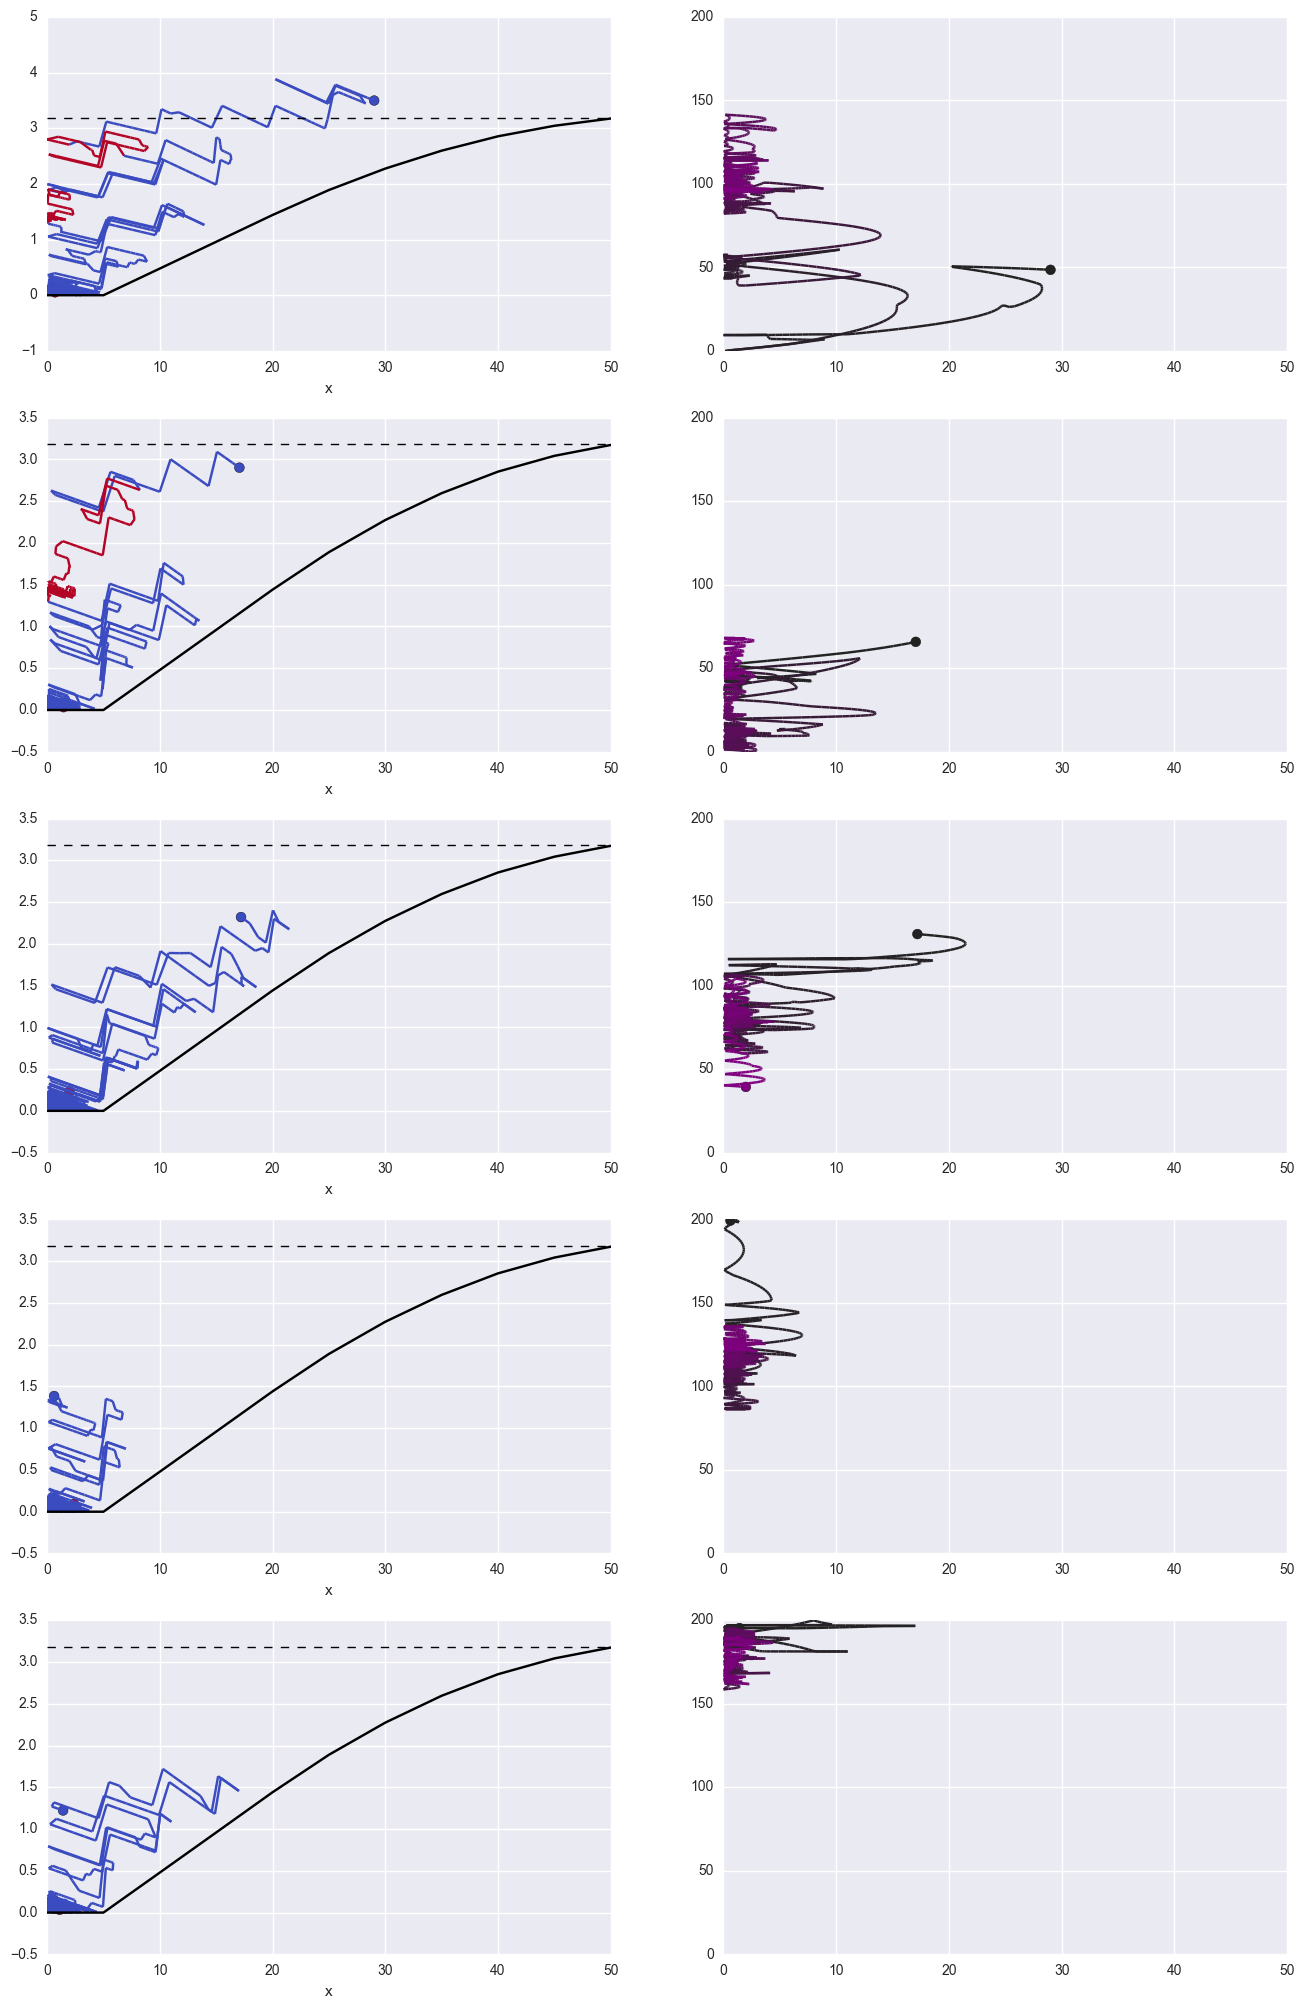

In [444]:
fig, axes = plt.subplots(len(pids), 2, figsize=(16, 5 * len(pids)))
for pid, ax in zip(pids, axes):
    plot_energy_band(tr, pid, ax=ax[0])
    plot_xy_trajectory(tr, pid, ax=ax[1])

In [309]:
tr.x.iloc[[0, -1]].as_matrix()

array([ 24.008  ,   2.34027])

In [221]:
def band_around(x):
    return band[band.x>=x].iloc[0].V

In [222]:
def plot_trajectory(pid):
    xx = tr[tr.id==pid].x
    yy = tr[tr.id==pid].Eadj + [band_around(_) for _ in xx]

    xmax = max(xx.max() * 1.1, 50.0)

    fig, ax = plt.subplots(1, 1)
    band.plot(x='x', y='V', ax=ax, xlim=(0, xmax))
    ax.plot(xx, yy)
    ax.axhline(y=3.18, c='k', ls='--')
    ax.scatter(xx.iloc[0], yy.iloc[0], c='k', s=50, zorder=10)
    ax.scatter(xx.iloc[-1], yy.iloc[-1], c='r', s=50, zorder=10)

In [267]:
from pprint import pprint
def ppr(array):
    pprint(array.tolist())
    print()

In [293]:
(np.random.random((1000, 2)) - 0.5).cumsum(axis=0)

array([[-0.0200685 ,  0.14514515],
       [-0.23382691,  0.46754475],
       [-0.49426726,  0.5818289 ],
       ..., 
       [-7.25062752,  5.34454716],
       [-7.39364842,  5.21554131],
       [-7.23743504,  5.68819819]])

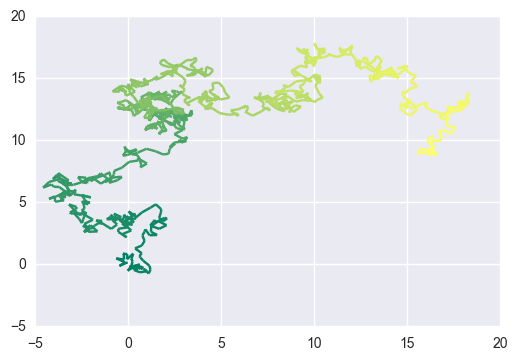

In [292]:
xy = (np.random.random((1000, 2)) - 0.5).cumsum(axis=0)
# ppr(xy)
xy = xy.reshape(-1, 1, 2)
# ppr(xy)
segments = np.hstack([xy[:-1], xy[1:]])
# ppr(segments)

coll = LineCollection(segments, cmap=plt.cm.summer)
coll.set_array(np.arange(0.0, 1.0, 1.0 / xy.shape[0]))

fig, ax = plt.subplots()
ax.add_collection(coll)
ax.autoscale_view()

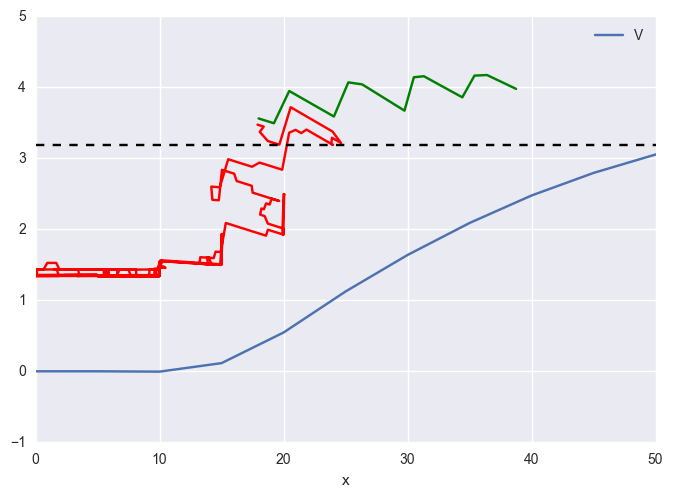

In [229]:
xx1 = tr[(tr.id==pid) & (tr.valley==1)].x
yy1 = tr[(tr.id==pid) & (tr.valley==1)].Eadj + [band_around(_) for _ in xx1]
xx2 = tr[(tr.id==pid) & (tr.valley==2)].x
yy2 = tr[(tr.id==pid) & (tr.valley==2)].Eadj + [band_around(_) for _ in xx2]

fig, ax = plt.subplots(1, 1)
band.plot(x='x', y='V', ax=ax, xlim=(0, 50))
ax.plot(xx1, yy1, c='g')
ax.plot(xx2, yy2, c='r')
ax.axhline(y=3.18, c='k', ls='--')
# ax.scatter(xx.iloc[0], yy.iloc[0], c='k', s=50, zorder=10)
# ax.scatter(xx.iloc[-1], yy.iloc[-1], c='r', s=50, zorder=10)

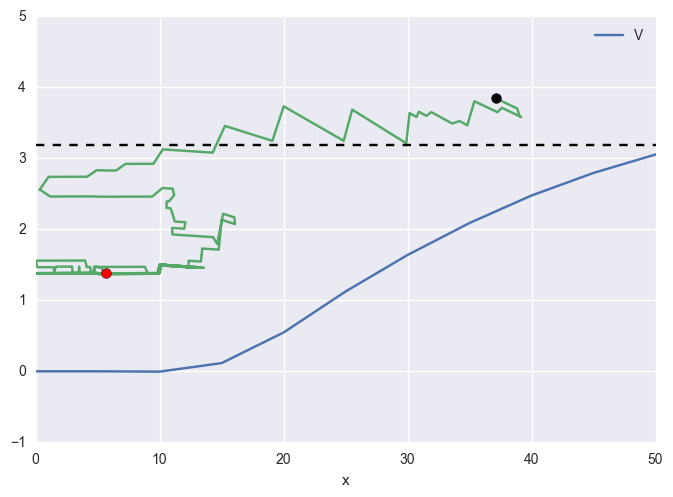

In [226]:
plot_trajectory(250000)

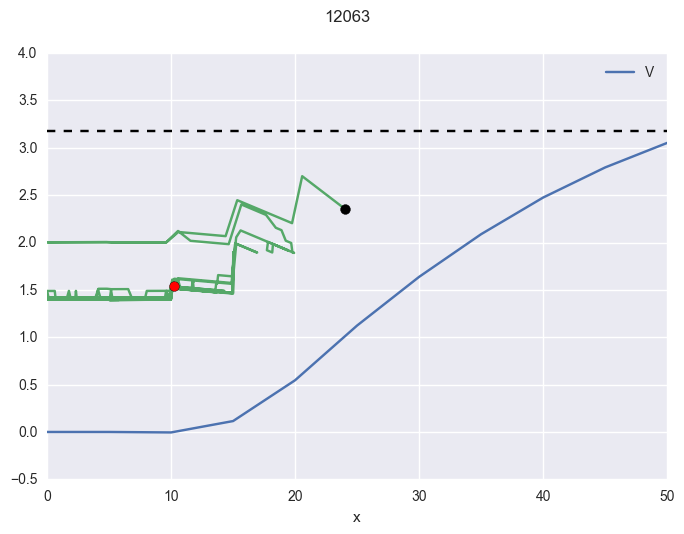

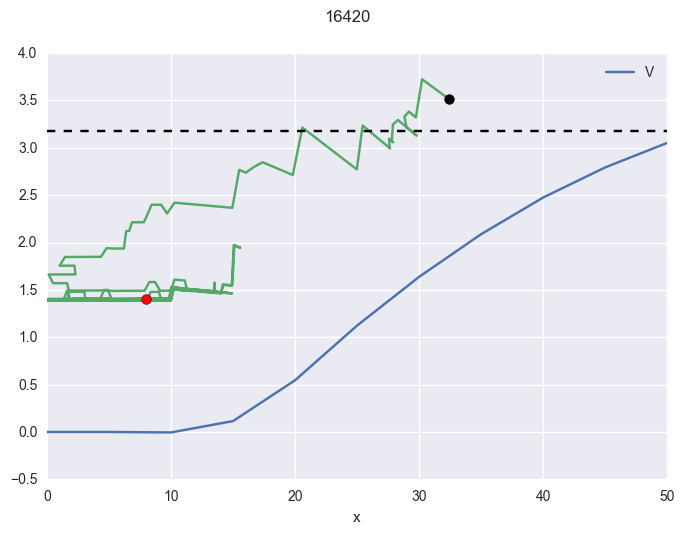

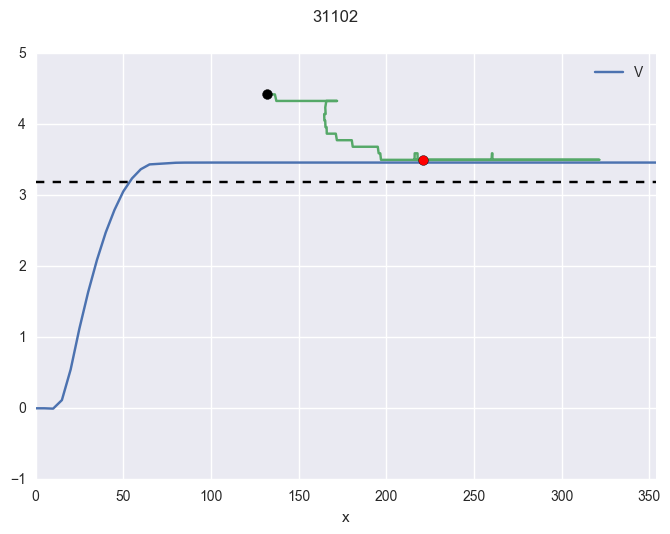

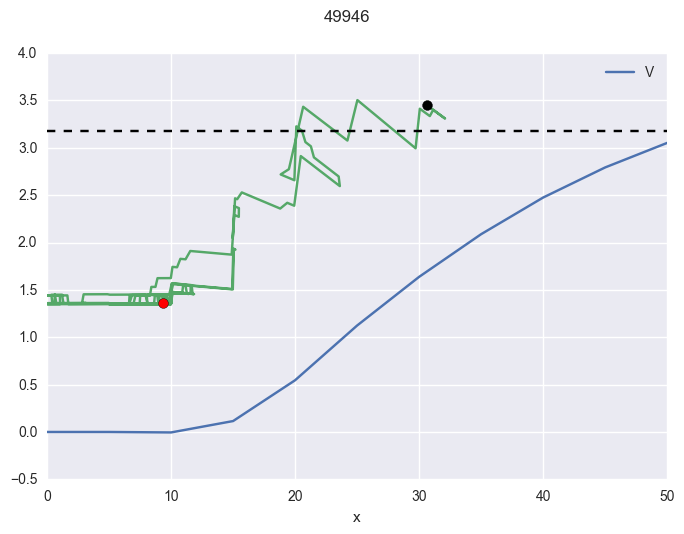

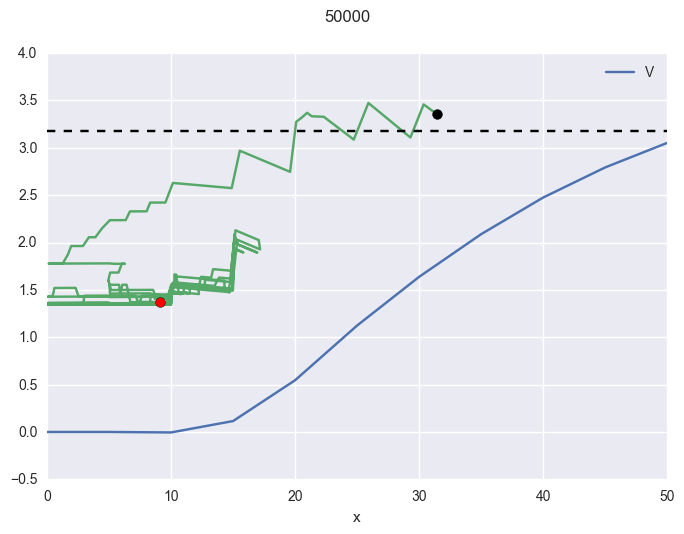

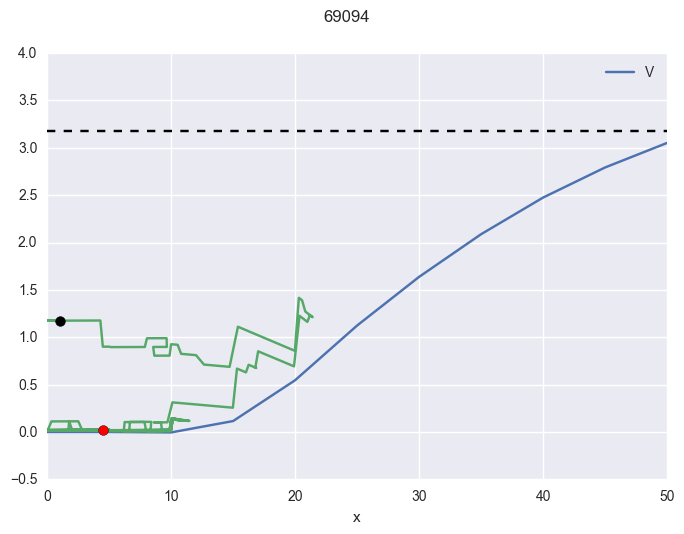

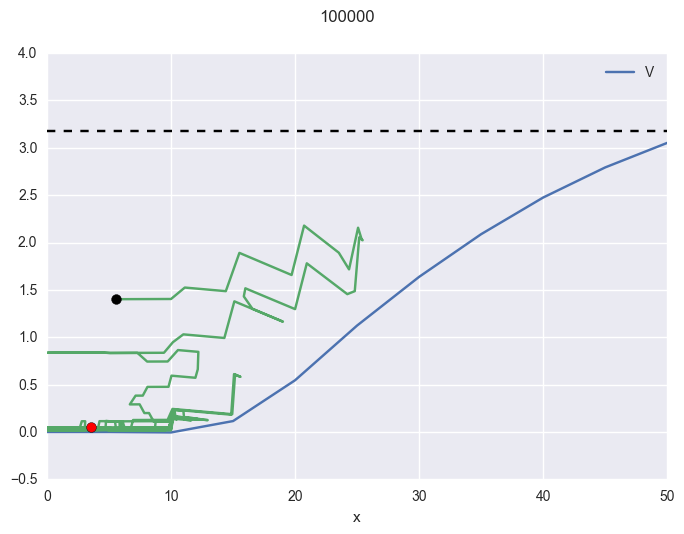

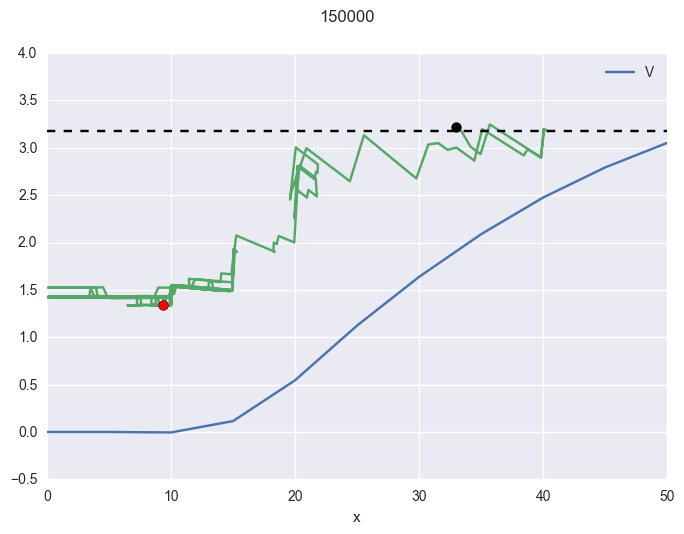

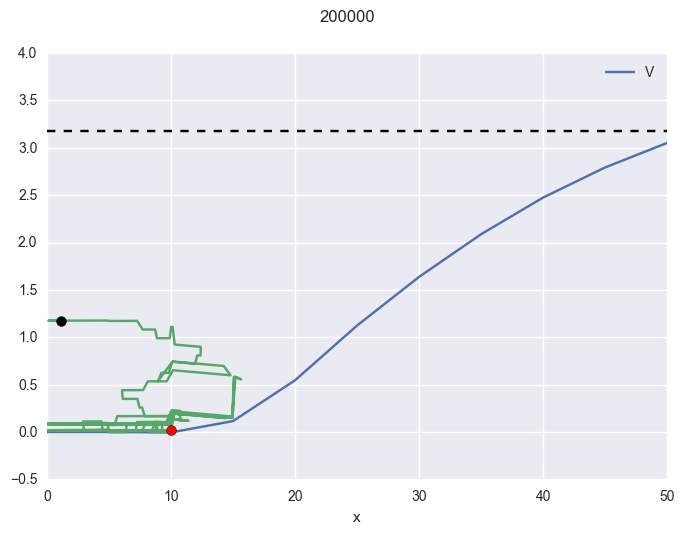

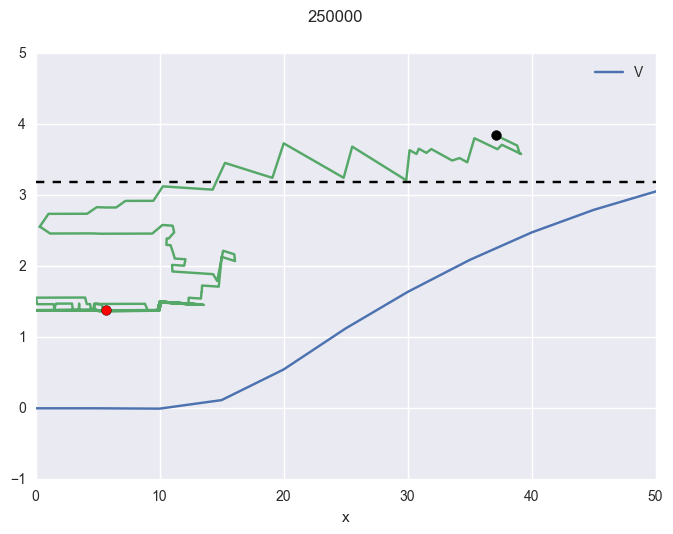

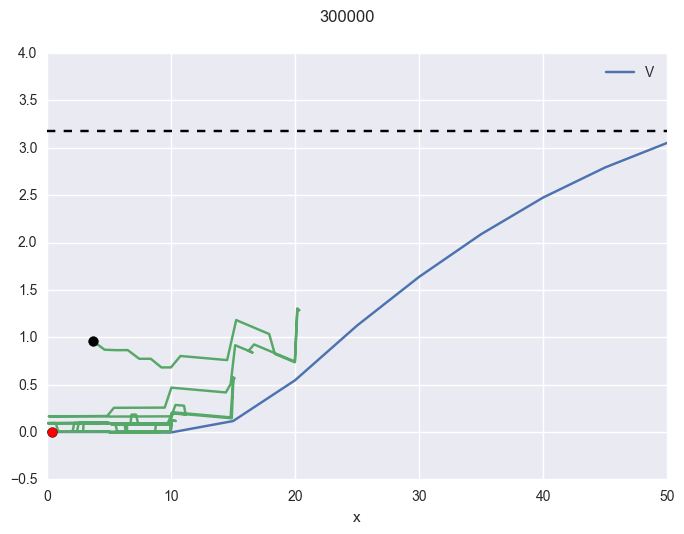

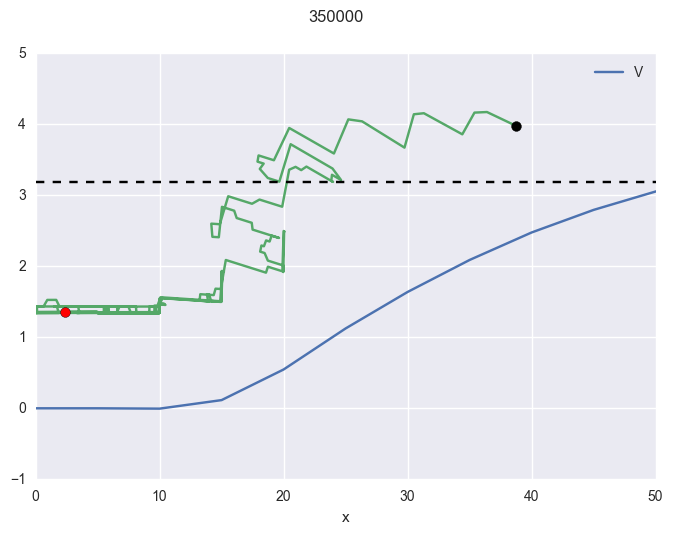

In [223]:
for pid in pids:
    plot_trajectory(pid)
    plt.suptitle(pid)